#### **import important libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import re
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold

In [2]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### **load data**

In [3]:
path = 'IMDB_Dataset.csv'
data = pd.read_csv(path)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### **preprocess data**

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
def remove_special_characters(review):
    """
    Remove Special character
    with regular expression ==> [^a-zA-Z0-9\s]
    """
    return re.sub(r"[^a-zA-Z0-9\s]", '', review)

def remove_html_tags(review):
    """
    remove html tags using BeautifulSoup
    and use lxml library as a backend parser
    """
    return BeautifulSoup(review, 'lxml').get_text()

def clean_text(review):
    """
    Clean the review text:
    - Remove HTML tags
    - Remove special characters
    - Convert to lowercase
    """
    # Remove HTML tags using BeautifulSoup
    review = remove_html_tags(review)
    # Remove special characters and numbers
    review = remove_special_characters(review)
    # Convert to lowercase and strip spaces
    review = review.lower().strip()
    
    return review

def remove_stopwords(text, stop_words):
    """
    Remove stop words from the text.
    """
    return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

def apply_stemming(text, stemmer):
    """
    Apply stemming to reduce words to their root form.
    """
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def apply_lemmatizing(text, lemmatizer):
    """
    Apply stemming to reduce words to their root form.
    """
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

def preprocess_review(review):
    review = clean_text(review)
    review = remove_stopwords(review, stop_words)
    review = apply_lemmatizing(review, lemmatizer)
    return review


In [6]:
%%time
data['review'] = data['review'].apply(preprocess_review)
data

CPU times: total: 1min 46s
Wall time: 1min 47s


,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative


#### **split data**

In [7]:
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### **encode data**

In [8]:
y_train = y_train.map({'positive': 1, 'negative': 0})
y_test = y_test.map({'positive': 1, 'negative': 0})

#### **convert data to vector**

In [9]:
# Vectorizing with CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word')
X_train_vec_count = count_vectorizer.fit_transform(X_train)  # Learn vocabulary and transform training data
X_test_vec_count = count_vectorizer.transform(X_test)        # Transform test data using the same vocabulary

In [10]:
# Vectorizing with TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer='word')
X_train_vec_tfidf = tfidf_vectorizer.fit_transform(X_train)  # Learn vocabulary and transform training data
X_test_vec_tfidf = tfidf_vectorizer.transform(X_test)        # Transform test data using the same vocabulary

#### **creating logistic regression model**

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

##### **train model**

In [ ]:
# Count Vectorizer Logistic Regression
lg_model = LogisticRegression()
lg_model.fit(X_train_vec_count, y_train) # Train on count vectorized data

##### **evaluate model**

CountVectorizer Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89      5000
           1       0.88      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



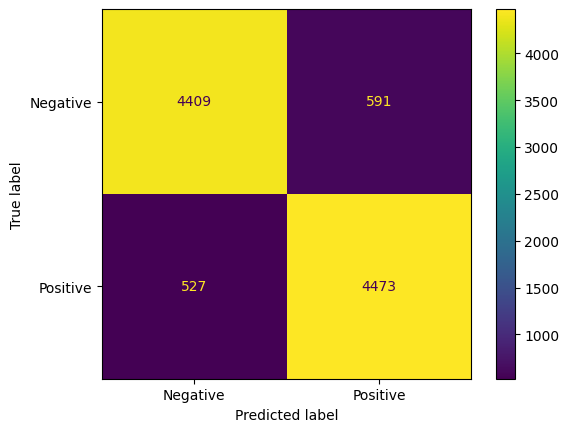

In [ ]:
y_pred = lg_model.predict(X_test_vec_count)                # Predict on test data
cm = confusion_matrix(y_test, y_pred)                      # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
print("CountVectorizer Classification Report:\n", classification_report(y_test, y_pred))

#### **there is an overfitting problem**

In [13]:
print(accuracy_score(y_train, lg_model.predict(X_train_vec_count)))
print(accuracy_score(y_test, lg_model.predict(X_test_vec_count)))

0.995925
0.8882


#### **use cross validation and hyperparameter tuning**

In [ ]:
lg_cv_model = LogisticRegressionCV(
    Cs=15,
    cv=5,
    penalty='l2',
    scoring='accuracy',
    max_iter=10000,
    random_state=42,
    solver='lbfgs' #Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm
)
# count Vectorizer Logistic Regression
lg_cv_model.fit(X_train_vec_count, y_train)     

##### **evalute model**

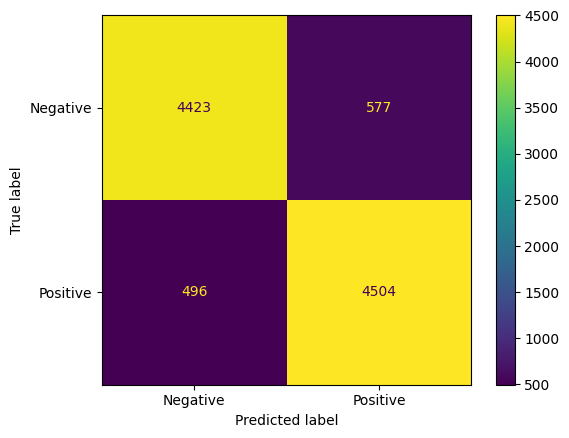

Count Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.89      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# Train on count vectorized data
y_pred = lg_cv_model.predict(X_test_vec_count)               # Predict on test data
cm = confusion_matrix(y_test, y_pred)                     # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.show()
print("Count Classification Report:\n", classification_report(y_test, y_pred))

##### **compare train data and test data**

In [16]:
print(accuracy_score(y_train, lg_cv_model.predict(X_train_vec_count)))
print(accuracy_score(y_test, lg_cv_model.predict(X_test_vec_count)))

0.960175
0.8927


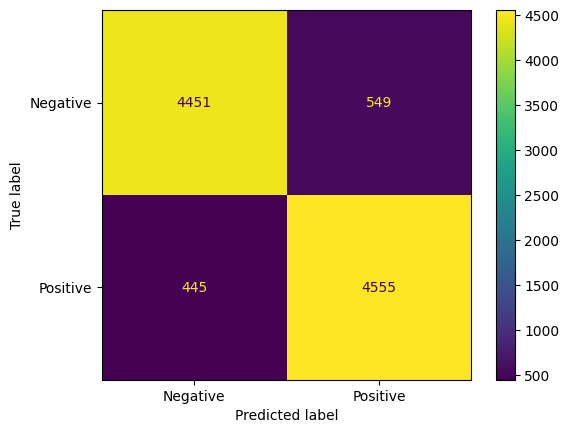

TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [17]:
# TF-IDF Vectorizer Logistic Regression
lg_cv_model.fit(X_train_vec_tfidf, y_train)                   # Train on TF-IDF vectorized data
y_pred = lg_cv_model.predict(X_test_vec_tfidf)               # Predict on test data
cm = confusion_matrix(y_test, y_pred)                     # Confusion matrix
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()
plt.show()
print("TF-IDF Classification Report:\n", classification_report(y_test, y_pred))

##### **compare train data and test data**

In [19]:
print(accuracy_score(y_train, lg_cv_model.predict(X_train_vec_tfidf)))
print(accuracy_score(y_test, lg_cv_model.predict(X_test_vec_tfidf)))

0.963825
0.9006
